### Read in data...

In [59]:
import pandas as pd

df = pd.read_csv("data.csv")

#check out what exists... (basic data exploration)
df.info()
df.isnull().sum()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2824 entries, 0 to 2823
Columns: 217 entries, record_id to interventions_complete
dtypes: float64(170), int64(2), object(45)
memory usage: 4.7+ MB


record_id                          0
redcap_repeat_instrument           0
redcap_repeat_instance             0
sex                             2189
socioeconomic_status___1        2180
                                ... 
other_intervention_setting_2    2813
date_of_other_intervention      2773
date_of_other_intervention_2    2813
date_of_other_intervention_3    2824
interventions_complete          2635
Length: 217, dtype: int64

# Data normalization
Adding and dropping columns before merging related rows

In [60]:
import re
#add some columns to hold the information im going to add in
df.insert(4, "numEntries_treatment_outcomes", 0)
df.insert(4, "numEntries_outpatient_readmission", 0)
df.insert(4, "numEntries_outpatient_lab", 0)
df.insert(4, "numEntries_outpatient_adverse", 0)
df.insert(4, "numEntries_interventions", 0)
df.insert(4, "numEntries_demographics", 0)
df.insert(4, "numEntries_antimicrobial_regimen", 0)

print(df.columns)

#drop all columns relating to dates. There is probably some info being lost there, but, even
#if someone has a start date they may not have an end date; this data is likely too full of missing values to
#reliably be useful for prediction. Even if it is included, the model may simply fit to those individuals who have
#*any* data there
i = 0
while (i < df.columns.shape[0]):
    thisColname = df.columns[i]
    #print(thisColname)
    matchy = re.search(".*date.*", thisColname)
    if (matchy != None):
        print("dropping column " + thisColname)
        df.drop(thisColname, axis=1, inplace=True)
        i -= 1
    i += 1
    
print("------------------------")
#print out the columns we have
for i in range (0, df.columns.shape[0]):
    print(str(i) + ": " + df.columns[i])
print(df.columns.shape)

Index(['record_id', 'redcap_repeat_instrument', 'redcap_repeat_instance',
       'sex', 'numEntries_antimicrobial_regimen', 'numEntries_demographics',
       'numEntries_interventions', 'numEntries_outpatient_adverse',
       'numEntries_outpatient_lab', 'numEntries_outpatient_readmission',
       ...
       'de_escalation_intervention_2', 'date_of_de_escalation_inte_2',
       'date_of_de_escalation_inte', 'other_intervention_setting_1',
       'other_intervention_setting_3', 'other_intervention_setting_2',
       'date_of_other_intervention', 'date_of_other_intervention_2',
       'date_of_other_intervention_3', 'interventions_complete'],
      dtype='object', length=224)
dropping column date_of_admission
dropping column opat_start_date
dropping column date_of_discharge
dropping column start_date_1
dropping column iv_abx_end_date_1
dropping column iv_orig_end_date_1
dropping column start_date_2
dropping column iv_abx_end_date_2
dropping column iv_orig_end_date_2
dropping column start

### Merge rows.
***
NOTE!! repeat rows appear to be a coincidence. e.g., labs taken which happen to have identical results. Number of labs could be an important feature.

In [61]:
import math
import numpy as np

#averages all non-NaN values
def mergeRows(rowlist):
    row = rowlist[0]
    p = row.shape[0]
    newRow = [row[0], row[1]]
    for i in range(2, p): #for ea col. Start at index 2 to skip over straight text
        avgval = 0
        numVals = 0
        for j in range(0, len(rowlist)): #for ea row
            thisRow = rowlist[j]
            thisVal = thisRow[i]
            if (not math.isnan(thisVal)):
                #print(thisVal)
                avgval += thisVal
                numVals += 1
        if (numVals != 0):
            newRow.append(avgval / numVals)
        else:
            newRow.append(-1)
    return np.array(newRow)


currentId = 1 #patient numbering starts at 1

#there could be repeats of basically any of this information...
antimicrobial_regimen = 0
demographics_opat = 0
interventions = 0
outpatient_adverse = 0
outpatient_lab = 0
outpatient_readmission = 0
treatment_outcomes = 0
patientRows = []

cleanData = []

for i in range(0, df.shape[0]):
    thisRow = df.iloc[i]
    thisId = thisRow[0]
    rowtype = thisRow[1]
    
    if (thisId == currentId): 
        patientRows.append(thisRow)
    else: #merge rows
        if (len(patientRows) > 0):
            merged = mergeRows(patientRows)
            merged[4] = antimicrobial_regimen
            merged[5] = demographics_opat
            merged[6] = interventions
            merged[7] = outpatient_adverse
            merged[8] = outpatient_lab
            merged[9] = outpatient_readmission
            merged[10] = treatment_outcomes
            cleanData.append(merged)
            #print("merge and append for index " + str(currentId))
        else:
            cleanData.append(thisRow)
            print("append for index " + str(currentId))
        
        #reset vars
        antimicrobial_regimen = 0
        demographics_opat = 0
        interventions = 0
        outpatient_adverse = 0
        outpatient_lab = 0
        outpatient_readmission = 0
        treatment_outcomes = 0
        patientRows = []
        currentId = thisId
    
    if (rowtype == "demographics_opat_setting_and_baseline_labs"):
        demographics_opat += 1
        
    elif (rowtype == "antimicrobial_regimen"):
        antimicrobial_regimen += 1
        
    elif (rowtype == "interventions"):
        interventions += 1
        
    elif (rowtype == "outpatient_adverse_events_not_requiring_hospitaliz"):
        outpatient_adverse += 1
        
    elif (rowtype == "outpatient_lab_monitoring"):
        outpatient_lab += 1
        
    elif (rowtype == "outpatient_readmission_and_ed_visits_up_to_post_90"):
        outpatient_readmission += 1
        
    elif (rowtype == "treatment_outcomes_and_extensions"):
        treatment_outcomes += 1
        
    else:
        raise Exception("Parse error: rowtype at index " + str(i) + " did not match any rowtype.")
        
newdf = pd.DataFrame(data=cleanData, columns=df.columns) #index 61 is missing
print(newdf.shape)



append for index 358
(604, 164)


### Clean up the last couple columns...

In [62]:
newdf.drop("record_id", axis=1, inplace=True)
newdf.drop("redcap_repeat_instrument", axis=1, inplace=True)
newdf.drop("redcap_repeat_instance", axis=1, inplace=True)
newdf = newdf.apply(pd.to_numeric) #for some reason, the default data type for these cols is strings...

#force any naughty nans to -1s.
newdf.fillna(-1, inplace=True)
    
#verify data is clean
print(newdf.isnull().values.any())

print(newdf.columns)


False
Index(['sex', 'numEntries_antimicrobial_regimen', 'numEntries_demographics',
       'numEntries_interventions', 'numEntries_outpatient_adverse',
       'numEntries_outpatient_lab', 'numEntries_outpatient_readmission',
       'numEntries_treatment_outcomes', 'socioeconomic_status___1',
       'socioeconomic_status___2',
       ...
       'dot_intervention_setting', 'dot_intervention_setting_2',
       'dot_line_days_avoided', 'dot_line_days_avoided_2',
       'de_escalation_intervention', 'de_escalation_intervention_2',
       'other_intervention_setting_1', 'other_intervention_setting_3',
       'other_intervention_setting_2', 'interventions_complete'],
      dtype='object', length=161)


### Generate labels.
Uses the following ordinal scale to generate labels, as described by Dr. Yen:
***
1= most desired outcome, 8=least desired outcome
***
1: No adverse drug event, no adverse line-related event, no readmission or ER visit

2: +Adverse drug event, no adverse line-related event, no readmission or ER visit

3: No adverse drug event,  +adverse line-related event, no readmission or ER visit

4: +Adverse drug event, +adverse line-related event, no readmission or ER visit

5: No adverse drug event, no adverse line-related event, +readmission or ER visit

6: No adverse drug event, +adverse line-related event, +readmission or ER visit

7:+Adverse drug event, no adverse line-related event, +readmission or ER visit

8: +Adverse drug event, +Adverse line-related event, +readmission or ER visit
***
NOTE: num readmissions, etc may not line up exactly with counts on original spreadsheet, since a single patient may have multiple readmissions

In [63]:
#given integer counts, generates some true label y_i
def label(numAdDrug, numAdLine, numRead): #ADR == adverse drug reaction; line-related ADR; numRead = calculated already
    drug = (numAdDrug > 0)
    line = (numAdLine > 0)
    read = (numRead > 0)
    
    if ( (not drug) and (not line) and (not read)):
        return 1
    if ( (drug) and (not line) and (not read)):
        return 2
    if ( (not drug) and (line) and (not read)):
        return 3
    if ( (drug) and (line) and (not read)):
        return 4
    if ( (not drug) and (not line) and (read)):
        return 5
    if ( (not drug) and (line) and (read)):
        return 6
    if ((drug) and (not line) and (read)):
        return 7
    return 8 #drug, line, read

#uncomment as needed
adrCols = [119, 120, 122] #Alternative Antimicrobial; Dose Adjustment; Other (describe the outcome of the..)
lineCols = [121] #124: outcome of the ADR_4 (line holdiday)
readmitCols = [6] #9; 127->137. (9 should encode 127->137)
for j in range(0, newdf.columns.shape[0]):
     print("j: " + str(j) + ": " + str(newdf.columns[j]))

y = []

for i in range (0, newdf.shape[0]):
    thisRow = newdf.iloc[i]
    adr = 0
    line = 0
    readmit = 0
    
    adr1 = thisRow[119]
    adr2 = thisRow[120]
    adr3 = thisRow[122]
    linehol = thisRow[121] #doesn't appear to ever be true but... I guess thats a result in and of itself?
    readmitVal = thisRow[6]
    if ((adr1 > 0) or (adr2 > 0) or (adr3 > 0)):
        adr = 1
    if (linehol > 0):
        line = 1
    if (readmitVal > 0):
        readmit = 1
    yi = label(adr, line, readmit)
    y.append(yi)

y = np.array(y)
print("Done")

#seems as though the label() fun works correctly... very few people appear to be non-1 on the ordinal scale.
# print(label(0, 0, 0)) #1
# print(label(1, 0, 0)) #2
# print(label(0, 1, 0)) #3
# print(label(1, 1, 0)) #4
# print(label(0, 0, 1)) #5
# print(label(0, 1, 1)) #6
# print(label(1, 0, 1)) #7
# print(label(1, 1, 1)) #8

ordinalNum = 0
ord2 = 0
ord5 = 0
ord7 = 0
for i in range(0, len(y)):
    if (y[i] != 1):
        ordinalNum += 1
    if (y[i] == 2):
        ord2 += 1
    elif (y[i] == 5):
        ord5 += 1
    elif (y[i] == 7):
        ord7 += 1
    else:
        if (y[i] != 1):
            print(y[i])
#     if (y[i] == 7): #(for checking that the label stuff is working)
#         print("index:")
#         print(i)
#         row = newdf.iloc[i]
#         for j in range(0, row.shape[0]):
#             print(str(j) + ", " + str(newdf.columns[j]) + ": " + str(row[j]))
        
        
print("Number of y_i != 1: " + str(ordinalNum)) #66% ordinal scale of 1
print("%y_i != 1: " + str(ordinalNum / len(y))) #34% other (3% 2, 29% 5, 2% 7). Doesnt sum to 34 bc rounding.
print("%y_i == 2: " + str(ord2 / len(y)))
print("%y_i == 5: " + str(ord5 / len(y)))
print("%y_i == 7: " + str(ord7 / len(y)))





j: 0: sex
j: 1: numEntries_antimicrobial_regimen
j: 2: numEntries_demographics
j: 3: numEntries_interventions
j: 4: numEntries_outpatient_adverse
j: 5: numEntries_outpatient_lab
j: 6: numEntries_outpatient_readmission
j: 7: numEntries_treatment_outcomes
j: 8: socioeconomic_status___1
j: 9: socioeconomic_status___2
j: 10: socioeconomic_status___3
j: 11: socioeconomic_status___4
j: 12: socioeconomic_status___5
j: 13: socioeconomic_status___6
j: 14: inpatient_start
j: 15: id_consult
j: 16: indication_for_opat___10
j: 17: indication_for_opat___1
j: 18: indication_for_opat___3
j: 19: indication_for_opat___11
j: 20: indication_for_opat___4
j: 21: indication_for_opat___5
j: 22: indication_for_opat___6
j: 23: indication_for_opat___7
j: 24: indication_for_opat___12
j: 25: indication_for_opat___8
j: 26: indication_for_opat___9
j: 27: opat_setting
j: 28: any_other_opat_setting
j: 29: opat_setting_2
j: 30: line_access_type___1
j: 31: line_access_type___2
j: 32: line_access_type___3
j: 33: line_acc

### Drop the last couple columns

In [64]:
#drop cols related: (partitioned out for human readability)
dropColsADR = [4, 117, 118, 119, 120, 122] #117-122: encode ADRs; 4 -> adr
dropColsLine = [121]
#6 == numreadmissions; 148 is "treatment outcomes and extensions complete." Seems to be more outcomes stuff
dropColsReadmit = [6, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, \
                   136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148] 
dropColsADR.extend(dropColsLine)
dropColsADR.extend(dropColsReadmit)
dropColsADR.sort()

colLabels = []
for j in range(0, len(dropColsADR)):
    thisInd = dropColsADR[j]
    thisColName = newdf.columns[thisInd]
    colLabels.append(thisColName)
    
for j in range(0, len(colLabels)):
    print("dropping column " + str(colLabels[j]))
    newdf.drop(colLabels[j], axis=1, inplace=True)
        
print(newdf.shape)


dropping column numEntries_outpatient_adverse
dropping column numEntries_outpatient_readmission
dropping column outpatient_lab_monitoring_complete
dropping column type_of_adr
dropping column what_was_the_outcome_of_th___1
dropping column what_was_the_outcome_of_th___2
dropping column what_was_the_outcome_of_th___4
dropping column what_was_the_outcome_of_th___5
dropping column were_there_any_readmission
dropping column was_the_patient_readmitted
dropping column reason_for_readmit___1
dropping column reason_for_readmit___6
dropping column reason_for_readmit___2
dropping column reason_for_readmit___3
dropping column reason_for_readmit___4
dropping column reason_for_readmit___5
dropping column was_id_consulted_during_th
dropping column was_the_original_opat_plan
dropping column hospital_length_of_stay
dropping column outpatient_readmission_and_ed_visits_up_to_post_90_complete
dropping column treatment_outcome_at_30_pofavo
dropping column unfavorable_30_day
dropping column unable_to_assess_

## final normalization: 
lets shift all values up by one, such that no_entry = 0; item_no: 0->1, item_yes: 1->2,
to avoid any potential weirdness with negative weights.
Then, normalize based on standard dev & mean.

In [65]:


#normalize: X - avg(x) / sigma
def normalizeX(X):
    avg = np.average(X, axis=0)
    sigma = np.std(X, axis=0)
    X = X - avg
    X = X / ((sigma) + 1e-10)
    
    #verify that this is equivalent to soln manual code
    data_mean = X.mean(axis = 0)[None ,:]
    data_std = X.std(axis = 0)[None,:] + 1e-10
    train_data = (X - data_mean) / data_std
    
    print(np.allclose(train_data, X))
    
    return X

# get X.
X = newdf.to_numpy(copy=True)
print(X.shape)
print(y.shape)


#normalize
X = normalizeX(X)


(604, 128)
(604,)
True


# SVD impl
(Naive method) Uses the power method to compute the SVD.
NOTE! Because the power method is used, there is a very small but nonzero chance that this algorithm will fail. The code is written such that it will warn us if there is an issue. Make sure you watch the output.

In [66]:
import copy

#calculates the power iteration (first left singular vector)
#for some symmetrix matrix A. Stops after n iterations.
#shamelessly copy-pasted from my hw5(?) solution
def powerIteration(A, n):
    v_prev = np.random.rand(A.shape[1]) #start off with some random garbage
    for _ in range(n):
        thisV = A @ v_prev
        thisNorm = np.linalg.norm(thisV)
        thisV = thisV / thisNorm
        v_prev = thisV

    return v_prev

#calculates the svd naively. 
#Based off of the algorithm discussed in "https://towardsdatascience.com/simple-svd-algorithms-13291ad2eef2"
def mySvd(X):
    
    n, p = X.shape

    u_arr = []
    s_arr = []
    v_arr = []

    for i in range(0, min(n, p)):
        thisX = X.copy() #copy.deepcopy(X) seems to fail for some reason??
       
        for j in range (0, i):
            thisX -= s_arr[j] * np.outer(u_arr[j], v_arr[j]) #need to use np.outer() because u, v are shape(#,); (v.T = v)
         
        if (n > p):
            X_v = thisX.T @ thisX
            v = powerIteration(X_v, 1000)
            u_base = X @ v
            sigma = np.linalg.norm(u_base)
            u = u_base / sigma
        else:
            X_u = thisX @ thisX.T
            u = powerIteration(X_u, 1000)
            v_base = X.T @ u
            sigma = np.linalg.norm(v_base)
            v = v_base / sigma
            
        u_arr.append(u)
        s_arr.append(sigma)
        v_arr.append(v)
    
    
    u_arr = np.array(u_arr).T
    v_arr = np.array(v_arr)
    s_arr = np.array(s_arr)

    return (u_arr, s_arr, v_arr)

#takes a while to calculate...
print("calculating svd using power method...")

u, s, vt = mySvd(X)

print("done!")

calculating svd using power method...


### Compare the results with numpy's svd algorithm. Note, there may be some variation as the power method is forced to find singular values for i > r, where r is rank(X)

In [ ]:
#test matrix:
#X = np.array([[1, 2, 3], [0, 1, 2], [-3, 0, 10], [0, 1, 2]], dtype=np.float64)
#print(X)

my_u, my_s, my_vt = mySvd(X)
print("calculating svd using numpy...")
u, s, vt = np.linalg.svd(X)

print(my_u.shape)
print(my_s.shape)
print(my_vt.shape)

print("---------")
print(u.shape)

#force u to a rank r shape
numToDelete = u.shape[1] - my_u.shape[1]
print("Forcing u to be rank r; deleting " + str(numToDelete) + " columns.")
for i in range(0, numToDelete):
    lastInd = u.shape[1] - 1
    u = np.delete(u, obj=lastInd, axis=1)
print(u.shape)
print(s.shape)
print(vt.shape)


u_correct = np.allclose(np.absolute(u), np.absolute(my_u))
sigma_correct = np.allclose(np.absolute(s), np.absolute(my_s))
v_correct = np.allclose(np.absolute(vt), np.absolute(my_vt))

if (not u_correct):
    print("u is not correct")
if (not sigma_correct):
    print("sigma is not correct")
if (not v_correct):
    print("v is not correct")
if (u_correct and sigma_correct and v_correct):
    print("all correct!")

## Do actual ML stuff
#### Plot the spectrum; looks like a 3D approximation should be sufficient.

Y converted to column vec. Shape of y: (604, 1)
num sigmas: 128


<IPython.core.display.Javascript object>


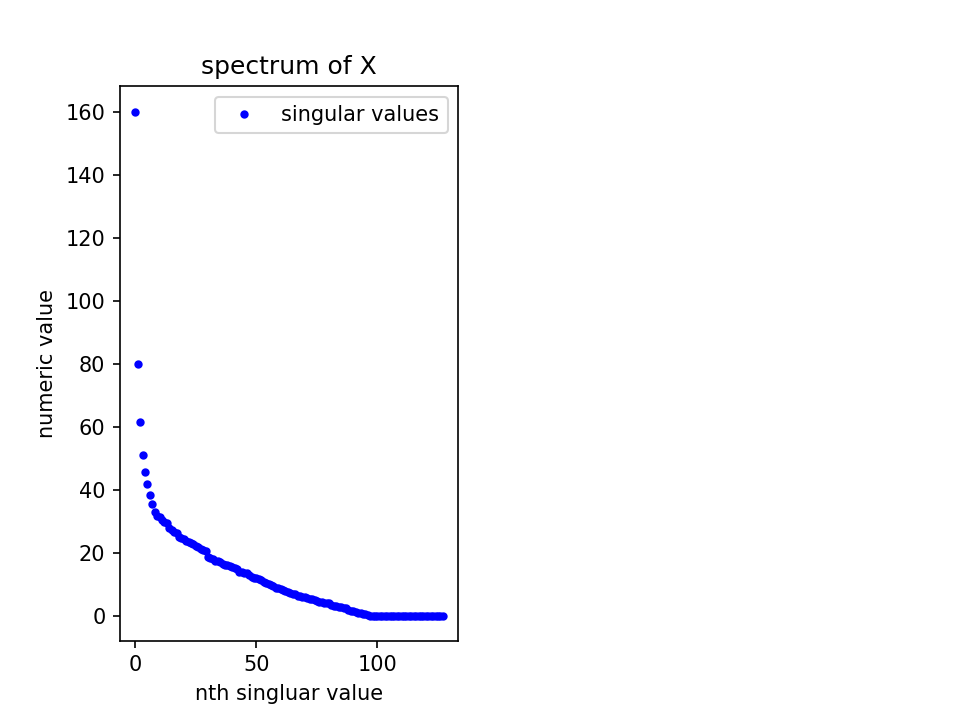

(604, 128)


In [112]:
%matplotlib notebook
import matplotlib.pyplot as plt

#Power iteration makes my laptop scream... (Uncomment as needed to check work regarding homebrew'd svd).
u, s, vt = np.linalg.svd(X) 

y = y.reshape(-1, 1)
print("Y converted to column vec. Shape of y: " + str(y.shape))

#plot the spectrum
print("num sigmas: " + str(s.shape[0]))

# display results
ax1 = plt.subplot(121)
sorted_indices = np.argsort(np.squeeze(y))
ax1.plot(
   range(s.shape[0]), s, 'b.'
)
ax1.set_title('spectrum of X')
ax1.set_xlabel('nth singluar value')
ax1.set_ylabel('numeric value')
ax1.legend(['singular values'], loc='upper right')

plt.show()

print(X.shape)

### Do PCA; plot 3-D projections, since it looks like we can have a nice 3D approximation
Column projection: X.T @ U
Row projection: X @ V

col proj, shape: (128, 3)
row proj, shape: (604, 3)


<IPython.core.display.Javascript object>


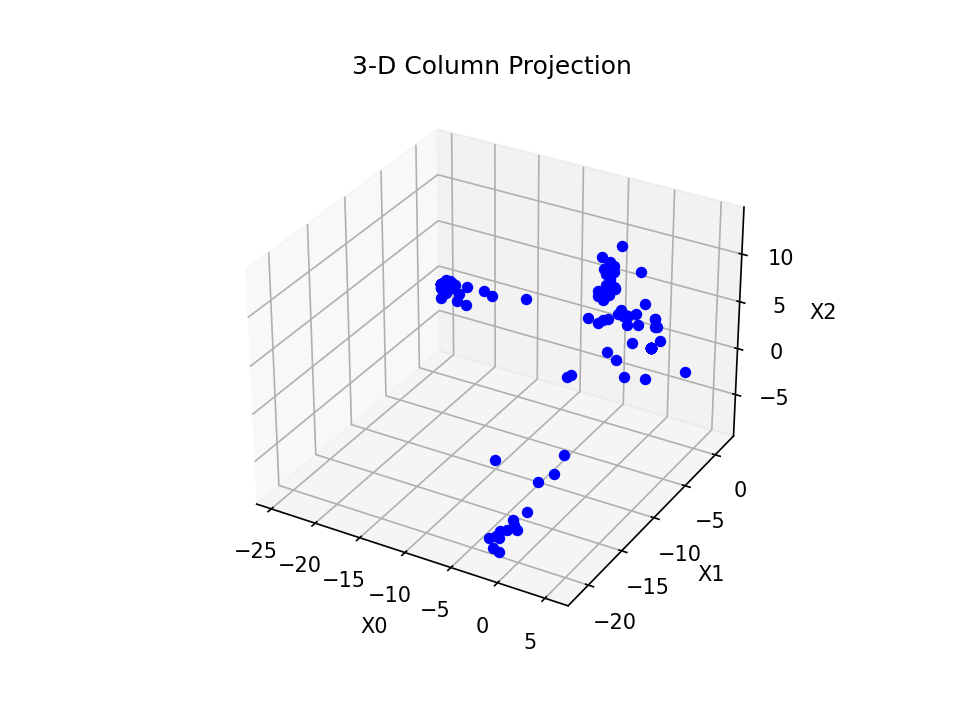

<IPython.core.display.Javascript object>


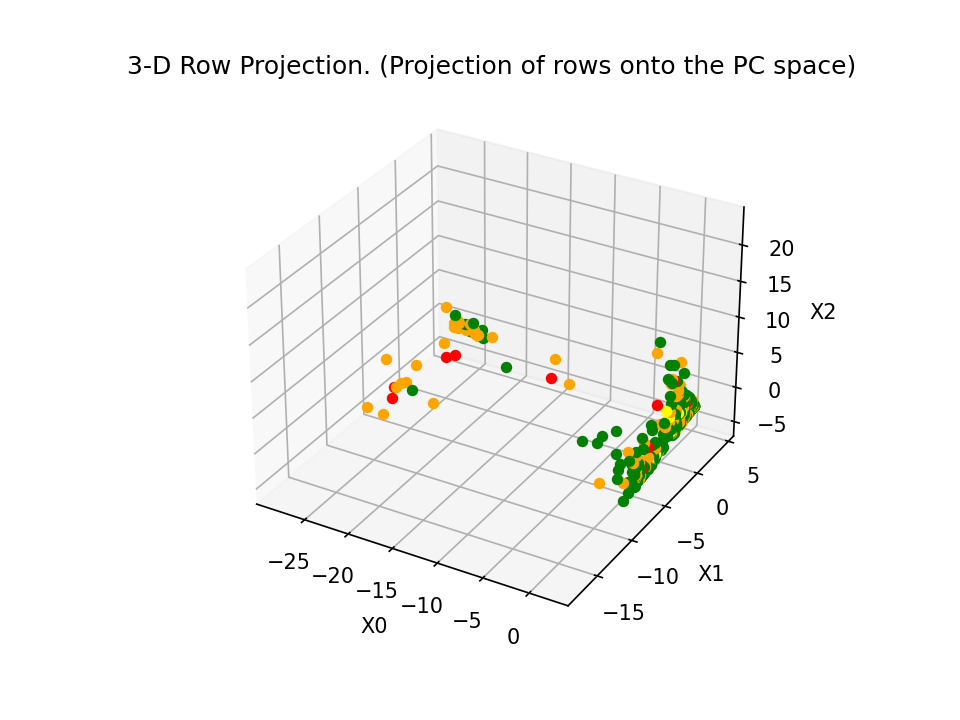

In [71]:
%matplotlib notebook
#first three columns of the matrix U will give you the best 3
#canonical basis vectors for approximating the column space of X

#When we do PCA, the j-th principal component is given by j-th column of
#XV and the coordinates of the i-th data point in the new PC space are given by the i-th row of XV.
v = vt.T

Uproj = u[:, 0:3]
Vproj = v[:, 0:3]

colProj = X.T @ Uproj
rowProj = X @ Vproj #Row projection is equal to the projection of the data onto the new PC space.

print("col proj, shape: " + str(colProj.shape))
print("row proj, shape: " + str(rowProj.shape))


#3-D plot (code modified from pyplot ex: https://matplotlib.org/stable/gallery/mplot3d/scatter3d.html)
############################col proj########################
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
i = 0
while (i < colProj.shape[0]):
   ax.scatter(colProj[i][0], colProj[i][1], colProj[i][2], color="b")
   i += 1

ax.set_xlabel('X0')
ax.set_ylabel('X1')
ax.set_zlabel('X2')
plt.title("3-D Column Projection")

plt.show()

############################row proj########################
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
i = 0
while (i < rowProj.shape[0]):
    patientLabel = y[i]
    if (y[i] == 1):
        ax.scatter(rowProj[i][0], rowProj[i][1], rowProj[i][2], color="green")
    if (y[i] == 2):
        ax.scatter(rowProj[i][0], rowProj[i][1], rowProj[i][2], color="yellow")
    if (y[i] == 5):
        ax.scatter(rowProj[i][0], rowProj[i][1], rowProj[i][2], color="orange")
    if (y[i] == 7):
        ax.scatter(rowProj[i][0], rowProj[i][1], rowProj[i][2], color="red")
    i += 1

ax.set_xlabel('X0')
ax.set_ylabel('X1')
ax.set_zlabel('X2')

plt.title("3-D Row Projection. (Projection of rows onto the PC space)")

plt.show()

## Get naive what (with RR)

Num iterations: 132
average errors (Mean squared error) ridge regression
[44.307304511387215, 0.2754425533405667, 0.26648952893002203, 0.26642149953781324, 0.26622177675953124, 0.2665241419964807, 0.0, 0.0, 0.0, 0.0]


<IPython.core.display.Javascript object>


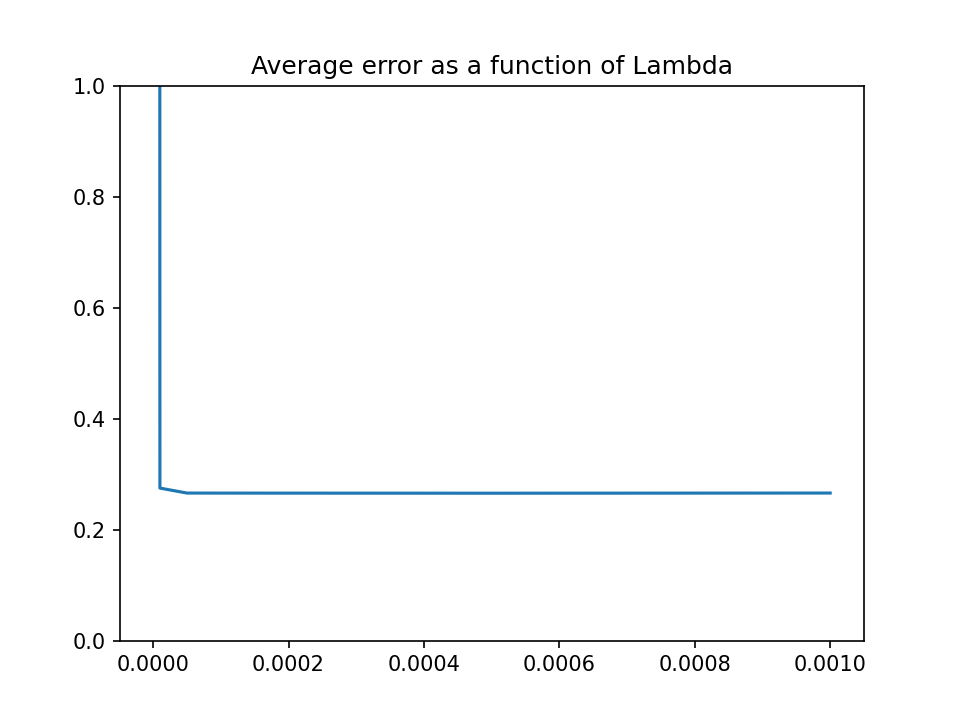

In [119]:
%matplotlib notebook

def getRRw(trainX, trainY):
    #w_RR = (X^TX + \lambda I) ^ -1 X^T y; 
    n, p = trainX.shape
    lams = [0.000001, 0.00001, 0.00005, 0.0001, 0.0005, 0.001]
    wRRs = []
    for i in range(0, len(lams)):
        lambdaTerm = lams[i] * np.identity(p) #I should be pxp to match dims of XTX
        invert = np.linalg.inv( (trainX.T @ trainX) + lambdaTerm )
        thisW = invert @ trainX.T @ trainY
        wRRs.append(thisW)
    return wRRs

def getMSE(yhat, y):

    sumOfSqDiff = 0
    for i in range(0, yhat.shape[0]):
        diff = yhat[i] - y[i]
        diff = diff * diff #square it
        sumOfSqDiff += diff
    sumOfSqDiff /= yhat.shape[0]

    return sumOfSqDiff

#get performance
#get hold out sets
setsX = []
setsY = []
for i in range(0, 12):
    thisHoldOut = X[i:i+50, :]#want full col, certain rows
    setsX.append(thisHoldOut)
    setsY.append(y[i:i+50, :])

#train/test on all choices of the two hold out sets
avgErrors = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0] #list; based on w1, w2, ... etc
optWs = []
optWInd = 3 #######################SET OPTIMAL W BASED ON MANUAL INSPECTION OF RESULTS ###############
numIters = 0
for i in range(0, 12):
    firstX = setsX[i]
    firstY = setsY[i]
    for j in range(0, 12):
        if (i != j):
            secondX = setsX[j]
            secondY = y[j:j+50, :]
            testY = np.append(firstY, secondY, axis=0)
            testX = np.append(firstX, secondX, axis=0)
            
            #got the test set... just need the train set
            trainList = []
            ylist = []
            for k in range(0, 12):
                if (not (k == i or k == j)):
                    trainList.append(setsX[k])
                    ylist.append(setsY[k])
            
            #merge all possible other sets.
            trainX = np.append(trainList[0], trainList[1], axis=0)
            trainY = np.append(ylist[0], ylist[1], axis=0)
            
            for k in range(2, len(trainList)):
                trainX = np.append(trainX, trainList[k], axis=0)
                trainY = np.append(trainY, ylist[k], axis=0)
            
            #got the train/test; lets predict & get the error rate
            ws = getRRw(trainX, trainY)
            optWs.append(ws[optWInd].flatten())
            for k in range (0, len(ws)):
                thisYhat = testX @ ws[k]
                thisAvgError = getMSE(testY, thisYhat)[0]
                avgErrors[k] = thisAvgError + avgErrors[k]
                
            numIters += 1
            
print("Num iterations: " + str(numIters))

for i in range (0, len(avgErrors)):
    avgErrors[i] = avgErrors[i] / numIters
print("average errors (Mean squared error) ridge regression")
print(avgErrors)

#plot avg error as a function of lambda
plottingErrors = []
for element in avgErrors:
    if (element != 0):
        plottingErrors.append(element)
plt.plot([0.000001, 0.00001, 0.00005, 0.0001, 0.0005, 0.001], plottingErrors)
plt.ylim(0, 1)
plt.title("Average error as a function of Lambda")
plt.show()


### Same thing, but calculate average number of errors.


average errors, ridge regression
[0.18621212121212125, 0.18712121212121213, 0.186969696969697, 0.1872727272727273, 0.19151515151515153, 0.19530303030303026, 0.0, 0.0, 0.0, 0.0]


<IPython.core.display.Javascript object>


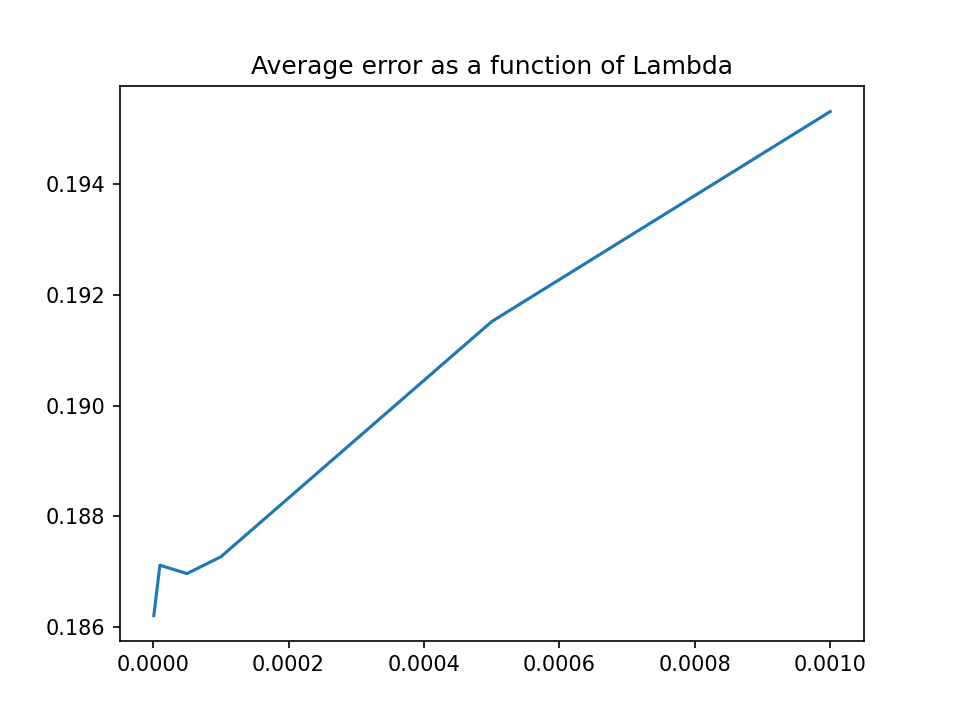

In [107]:
%matplotlib notebook

def getRRw(trainX, trainY):
    #w_RR = (X^TX + \lambda I) ^ -1 X^T y; 
    n, p = trainX.shape
    lams = [0.000001, 0.00001, 0.00005, 0.0001, 0.0005, 0.001]
    wRRs = []
    for i in range(0, len(lams)):
        lambdaTerm = lams[i] * np.identity(p) #I should be pxp to match dims of XTX
        invert = np.linalg.inv( (trainX.T @ trainX) + lambdaTerm )
        thisW = invert @ trainX.T @ trainY
        wRRs.append(thisW)
    return wRRs

def getAvgError(y, yhat):

    numErrors = 0.0
    for i in range(0, yhat.shape[0]):
        estimate = round(yhat[i][0])
        actual = y[i][0]
        if (estimate < 0):
            estimate = 1
        if (estimate > 8):
            estimate = 8
        if (estimate != actual):
#             print("incrementing num errors")
#             print("estimate: " + str(estimate) + " actual: " + str(actual))
            numErrors += 1
            
    numErrors /= yhat.shape[0]

    return numErrors

#get performance
#get hold out sets
setsX = []
setsY = []
for i in range(0, 12):
    thisHoldOut = X[i:i+50, :]#want full col, certain rows
    setsX.append(thisHoldOut)
    setsY.append(y[i:i+50, :])

#train/test on all choices of the two hold out sets
avgErrors = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0] #list; based on w1, w2, ... etc
numIters = 0
for i in range(0, 12):
    firstX = setsX[i]
    firstY = setsY[i]
    for j in range(0, 12):
        if (i != j):
            secondX = setsX[j]
            secondY = y[j:j+50, :]
            testY = np.append(firstY, secondY, axis=0)
            testX = np.append(firstX, secondX, axis=0)
            
            #got the test set... just need the train set
            trainList = []
            ylist = []
            for k in range(0, 12):
                if (not (k == i or k == j)):
                    trainList.append(setsX[k])
                    ylist.append(setsY[k])
            
            #merge all possible other sets.
            trainX = np.append(trainList[0], trainList[1], axis=0)
            trainY = np.append(ylist[0], ylist[1], axis=0)
            
            for k in range(2, len(trainList)):
                trainX = np.append(trainX, trainList[k], axis=0)
                trainY = np.append(trainY, ylist[k], axis=0)
            
            #got the train/test; lets predict & get the error rate
            ws = getRRw(trainX, trainY)
            
            for k in range (0, len(ws)):
                thisYhat = testX @ ws[k]
                thisAvgError = getAvgError(testY, thisYhat)
                avgErrors[k] = thisAvgError + avgErrors[k]
                
            numIters += 1


for i in range (0, len(avgErrors)):
    avgErrors[i] = avgErrors[i] / numIters
print("average errors, ridge regression")
print(avgErrors)

#plot avg error as a function of lambda
plottingErrors = []
for element in avgErrors:
    if (element != 0):
        plottingErrors.append(element)
plt.plot([0.000001, 0.00001, 0.00005, 0.0001, 0.0005, 0.001], plottingErrors)
plt.title("Average error as a function of Lambda")
plt.show()


### Calculate avg, std dev for each w_i

In [110]:
#avg = np.average(X, axis=0)
#sigma = np.std(X, axis=0)
optWs = np.array(optWs).T
avgW = np.average(optWs, axis=1) #feels like it should be a row-wise avg, but technically a column-wise average: "for each row, average over the columns"
#verify that its working as expected...
myAvg = []
for j in range(0, optWs.shape[0]): #for ea row
    jthAvgW = 0
    for k in range(0, optWs.shape[1]): #for ea col.
        jthAvgW += optWs[j][k]
    myAvg.append(jthAvgW / numIters)
myAvg = np.array(myAvg)
sigma = np.std(optWs, axis=1)
print(optWs.shape)
print(avgW.shape)
print(myAvg.shape)
print(np.allclose(myAvg, avgW))

(128, 132)
(128,)
(128,)
True


### Figure out which weights are largest

In [117]:

#figure out what weights are largest in magnitude

#this is... a particularly inefficient way of going about it... (basically selection sort...)
numToFind = 5
topPosIndices = []
topNegIndices = []
for i in range(0, numToFind):
    topPosIndices.append(-1)
    topNegIndices.append(-1)
    
for i in range(0, numToFind):
    thisTopPos = 0
    thisTopNeg = 0
    for j in range(0, avgW.shape[0]):
        thisVal = avgW[j]
        if (thisVal < 0):
            if ( (thisVal < thisTopNeg) and (j not in topNegIndices)):
                thisTopNeg = thisVal
                topNegIndices[i] = j
                

        else: #thisVal > 0
            if ((thisVal > thisTopPos) and (j not in topPosIndices)):
                thisTopPos = thisVal
                topPosIndices[i] = j
                
print("top pos indices: " + str(topPosIndices))
for j in topPosIndices:
    print(str(newdf.columns[j]) + ", average weight: " + str(avgW[j]) + ", average std dev: " + str(sigma[j]))
print("~~~~~~~~~~~~~~~~~~~")
print("top neg indices: " + str(topNegIndices))
for j in topNegIndices:
    print(str(newdf.columns[j]) + ", average weight:" + str(avgW[j]) + ", average std dev: " + str(sigma[j]))
    


top pos indices: [117, 102, 85, 124, 80]
line_days_avoided, average weight: 34.44505893133037, average std dev: 3.711613469335139
hematocrit, average weight: 9.066180141463642, average std dev: 0.4182458330101163
po_intended_dot_3, average weight: 6.977216881324582, average std dev: 0.3609263124724504
other_intervention_setting_1, average weight: 6.156401013423114, average std dev: 0.11988773979122604
po_abx_dot_2, average weight: 4.045481614632846, average std dev: 0.08696071613378385
~~~~~~~~~~~~~~~~~~~
top neg indices: [83, 101, 3, 78, 127]
po_abx_3, average weight:-24.49621708201321, average std dev: 0.5947074396116581
hemoglobin, average weight:-11.034845869268072, average std dev: 0.5281678039435312
numEntries_interventions, average weight:-4.745253073484341, average std dev: 0.21144557641507195
po_abx_ended, average weight:-4.099946965700417, average std dev: 0.7969764998030663
interventions_complete, average weight:-4.039562340669031, average std dev: 0.11436403146835888
~~~~~~

In [118]:
#Print w
print("Column Name, Weight, Standard Deviation")
for i in range (0, avgW.shape[0]):
    print(str(newdf.columns[i]) + ", " + str(avgW[i]) + ", " + str(sigma[i]))

Column Name, Weight, Standard Deviation
sex, 0.16599876399421792, 0.02020535585734979
numEntries_antimicrobial_regimen, 0.3641935462172205, 0.020528046013722018
numEntries_demographics, 0.5346862499307176, 0.03690853672806049
numEntries_interventions, -4.745253073484341, 0.21144557641507195
numEntries_outpatient_lab, -0.6547898890913989, 0.01028892143601112
numEntries_treatment_outcomes, 0.15229585095571654, 0.06419493491738339
socioeconomic_status___1, -0.25709864293996554, 0.048073534601916455
socioeconomic_status___2, -0.09711952229950013, 0.024233168118323493
socioeconomic_status___3, -0.10331745817954675, 0.020000177282494466
socioeconomic_status___4, -0.09912601563571805, 0.01966409039361808
socioeconomic_status___5, -0.22190239374652315, 0.038092569507580894
socioeconomic_status___6, 0.09527406622263314, 0.038779849232982125
inpatient_start, 0.10863079004145594, 0.028472005999684347
id_consult, 0.32109083171179503, 0.06513160125663336
indication_for_opat___10, 0.2716823025512648